In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!unzip -o '/content/drive/MyDrive/facialrecog.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/sad/Training_65242339.jpg  
  inflating: /content/dataset/train/sad/Training_65267116.jpg  
  inflating: /content/dataset/train/sad/Training_65275626.jpg  
  inflating: /content/dataset/train/sad/Training_6529266.jpg  
  inflating: /content/dataset/train/sad/Training_65329617.jpg  
  inflating: /content/dataset/train/sad/Training_65338712.jpg  
  inflating: /content/dataset/train/sad/Training_65338797.jpg  
  inflating: /content/dataset/train/sad/Training_65387162.jpg  
  inflating: /content/dataset/train/sad/Training_65404494.jpg  
  inflating: /content/dataset/train/sad/Training_65426218.jpg  
  inflating: /content/dataset/train/sad/Training_65430136.jpg  
  inflating: /content/dataset/train/sad/Training_65437377.jpg  
  inflating: /content/dataset/train/sad/Training_6545735.jpg  
  inflating: /content/dataset/train/sad/Training_65463385.jpg  
  inflating: /content/dataset/train/sad/Training_654739

In [64]:
import os

# Define the path to the dataset directory
dataset_path = '/content/dataset'

# Initialize a counter
total_images = 0

# Loop over all directories and files in the dataset directory
for dirpath, dirnames, filenames in os.walk(dataset_path):
    # Count only files that are likely to be images
    total_images += sum([1 for f in filenames if f.endswith(('.png', '.jpg', '.jpeg'))])

print(f"Total number of images in the dataset: {total_images}")


Total number of images in the dataset: 35887


In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to the dataset
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'


In [66]:
# Define the label dictionary outside the function for global access
categories = sorted(os.listdir(train_path))  # Ensure it's sorted for consistency
label_dict = {name: i for i, name in enumerate(categories)}


In [91]:
def load_data(data_path, label_dict):
    images = []
    labels = []
    for category in categories:
        class_folder = os.path.join(data_path, category)
        for img in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img)
            if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                image = plt.imread(img_path)
                if image.ndim == 2:
                    image = np.stack((image,)*3, axis=-1)
                elif image.shape[2] == 4:
                    image = image[..., :3]
                images.append(image)
                labels.append(label_dict[category])
    images = np.array(images, dtype=np.float32) / 255.0  # Normalize images
    labels = np.array(labels, dtype=int)  # Ensure labels are integers
    return images, labels

Total training images: 28709
Total testing images: 7178
Image shape: (48, 48, 3)
Number of classes: 7
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


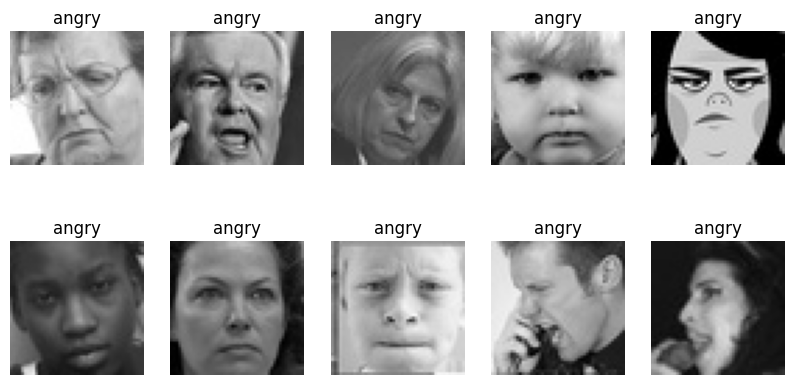

In [92]:
# Load train and test data
train_images, train_labels = load_data(train_path, label_dict)
test_images, test_labels = load_data(test_path, label_dict)

# Check the unique classes found and print information
num_classes = len(categories)
print("Total training images:", train_images.shape[0])
print("Total testing images:", test_images.shape[0])
print("Image shape:", train_images[0].shape)
print("Number of classes:", num_classes)
print("Classes:", categories)

# Visualizing the dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
    plt.title(list(label_dict.keys())[train_labels[i]])
    plt.axis('off')
plt.show()


In [93]:
# Convert labels to categorical (one-hot encoding)
train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

# Splitting the dataset for validation
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)



In [94]:
# ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [95]:
import os
from PIL import Image

def dataset_details(train_path):
    categories = os.listdir(train_path)
    num_classes = len(categories)
    image_sizes = []

    # Sample one image per category to determine size
    for category in categories:
        images = os.listdir(os.path.join(train_path, category))
        if images:
            img_path = os.path.join(train_path, category, images[0])
            with Image.open(img_path) as img:
                image_sizes.append(img.size)  # size returns (width, height)

    return num_classes, set(image_sizes)

train_path = '/content/dataset/train'
num_classes, image_sizes = dataset_details(train_path)
print("Number of classes:", num_classes)
print("Image sizes found in dataset:", image_sizes)


Number of classes: 7
Image sizes found in dataset: {(48, 48)}


In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def build_vgg13_model(input_shape, num_classes):
    model = Sequential([
        # First block
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Second block
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Third block
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Fully connected layers
        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Assuming input_shape is already set, for example:
input_shape = (48, 48, 3)  # Must match your dataset image size
num_classes = 7  # Adjusted to your dataset

# Build and compile the VGG-13 model
vgg13_model = build_vgg13_model(input_shape, num_classes)
vgg13_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary to confirm the configuration
vgg13_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_16 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_17 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                      

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Setup model checkpoint to only save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


In [74]:
import tensorflow as tf
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Train the model
history = vgg13_model.fit(
    train_generator,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
718/718 [==============================] - ETA: 0s - loss: 28.6654 - accuracy: 0.2129
Epoch 1: val_accuracy improved from -inf to 0.25496, saving model to best_model.h5
718/718 [==============================] - 35s 43ms/step - loss: 28.6654 - accuracy: 0.2129 - val_loss: 20.0517 - val_accuracy: 0.2550 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
718/718 [==============================] - ETA: 0s - loss: 14.6327 - accuracy: 0.2367
Epoch 2: val_accuracy improved from 0.25496 to 0.25566, saving model to best_model.h5
718/718 [==============================] - 31s 43ms/step - loss: 14.6327 - accuracy: 0.2367 - val_loss: 10.3390 - val_accuracy: 0.2557 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/20
718/718 [==============================] - ETA: 0s - loss: 7.8491 - accuracy: 0.25

In [98]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best_model.h5')

# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


180/180 [==============================] - 2s 8ms/step - loss: 1.3455 - accuracy: 0.6277
Test Accuracy: 62.77%
Test Loss: 1.3455


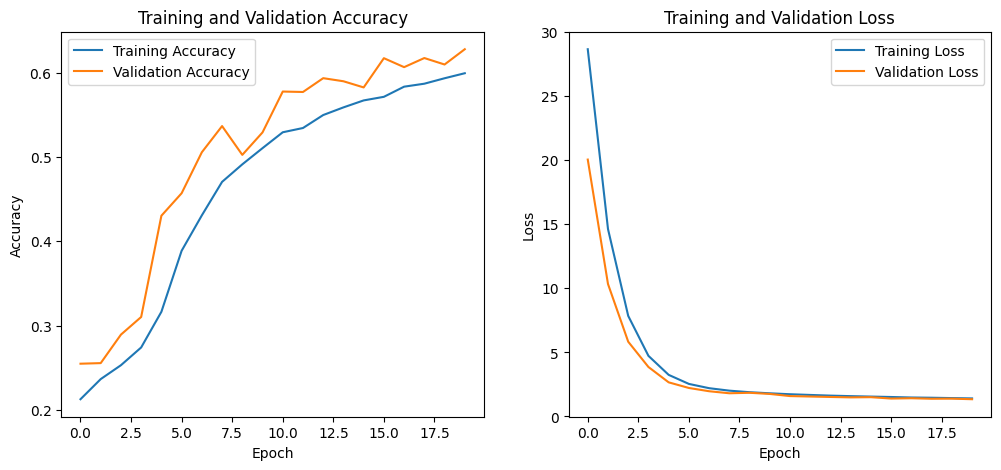

In [87]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [96]:
print("Shape of train_labels after loading and before encoding:", train_labels.shape)
train_labels = to_categorical(train_labels, num_classes=num_classes)
print("Shape of train_labels after one-hot encoding:", train_labels.shape)


Shape of train_labels after loading and before encoding: (28709, 7)
Shape of train_labels after one-hot encoding: (28709, 7, 7)


225/225 [==============================] - 2s 6ms/step


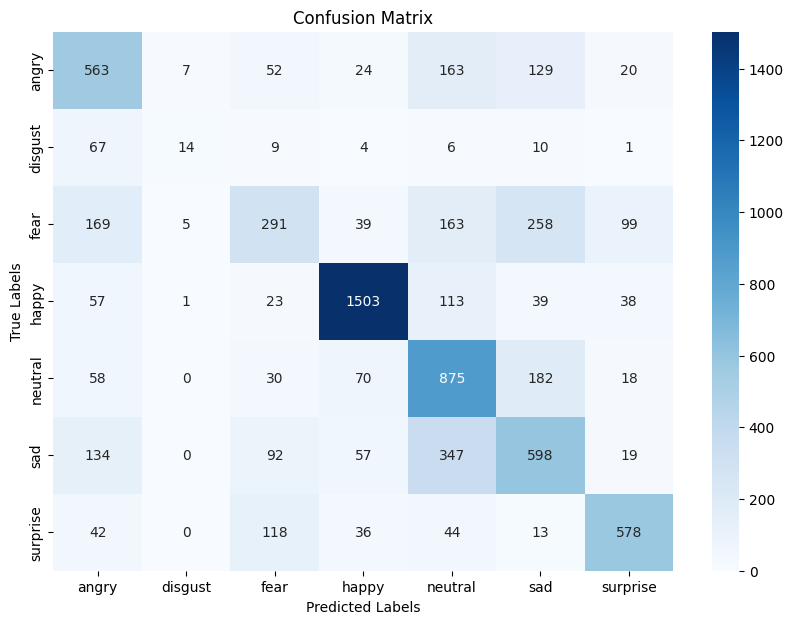

In [97]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best saved model
best_model = load_model('best_model.h5')

# Make predictions on the test set
predictions = best_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
